# Prepare Basin Averaged Forcing for NextGen CFE Model (New York City)

**Author:** [Javed Ali](https://www.javedali.net/) (University of Central Florida)  
    
**Date:** 06.26.2023   

**Description**:  

The purpose of this Jupyter Notebook is to prepare basin averaged forcing input from for the [NOAA Next Generation (NextGen) Water Resource Modeling Framework](https://github.com/NOAA-OWP/ngen) from AORC **v1.0** kerchunk header files.

**Link to data**:
- Original: https://noaa-nwm-retrospective-2-1-pds.s3.amazonaws.com/index.html#forcing/
- Kerchunk: https://ciroh-nwm-zarr-retrospective-data-copy.s3.amazonaws.com/index.html#noaa-nwm-retrospective-2-1-zarr-pds/

**Software Requirements**:  

The software and operating system versions used to develop this notebook are listed below. To avoid encountering issues related to version conflicts among Python packages, we recommend creating a new environment variable and installing the required packages specifically for this notebook.

Tested on: Windows (`python: 3.9.16`) 

> dask: 2023.5.1 \
  numpy: 1.24.3 \
    xarray: 2023.5.0 \
    pyproj: 3.5.0 \
    pandas: 2.0.2 \
    requests: 2.31.0 \
    geopandas: 0.13.2 \
    matplotlib: 3.7.1 \
    zarr: 2.15.0 \
    fsspec: 2023.6.0 \
    s3fs: 2023.6.0 \
    kerchunk:0.1.2 

<div class="alert alert-block alert-info">
<b>Acknowledgement:</b> This notebook is adapted from the code developed by CAUHSI team Tony Castronova and Irene Garousi-Nejad.
</div>

---

In [1]:
# install rioxarray and geocube
!pip install rioxarray -q
!pip install geocube -q

In [1]:
# data collection and manipulation
import re
import dask
import numpy
import xarray
import pandas as pd
import pandas
import requests
import zarr
import fsspec
from pyproj import Transformer
from s3fs import S3FileSystem
from kerchunk.combine import MultiZarrToZarr

# progress bar
from tqdm.notebook import tqdm

# geospatial analysis
import pyproj
import geopandas
import rioxarray
from geocube.api.core import make_geocube

# data viz
from matplotlib import colors
import matplotlib.pyplot as plt

# distributed computing
import xml.etree.ElementTree as ET
from dask.distributed import Client
from dask.distributed import progress

# system
import os

# ignore warnings
import warnings
warnings.filterwarnings("ignore")

%reload_ext watermark

In [2]:
%watermark

Last updated: 2023-07-16T23:56:11.843085+00:00

Python implementation: CPython
Python version       : 3.9.16
IPython version      : 8.14.0

Compiler    : GCC 11.3.0
OS          : Linux
Release     : 5.15.107+
Machine     : x86_64
Processor   : x86_64
CPU cores   : 14
Architecture: 64bit



Initiate the Dask client. This will enable us to parallelize our computations.

In [3]:
# use a try accept loop so we only instantiate the client
# if it doesn't already exist.
try:
    print(client.dashboard_link)
except:    
    # The client should be customized to your workstation resources.
    client = Client(n_workers=6, memory_limit='10GB') # per worker 
    print(client.dashboard_link)


proxy/8787/status


---

## Load Forcing Data into Memory

In this notebook we'll be working with AORC v1.0 meteorological forcing. These data are publicly available for the entire CONUS, spanning from 1980 to 2020. Kerchunk header files have been created by the Alabama Water Institute team and this is an ongoing project. Please note that this jupyter notebook works for data within 2007-2019, but it cannot work with data prior to 2006.  

In [4]:
# define the selected watershed boundary 
wb_id = 'wb-698891'
# wb_ids_list = ['wb-694856', 'wb-694725', 'wb-694855', 'wb-694724', 'wb-694854', 'wb-694723', 'wb-698891', 'wb-694722']

# define the year of interest
year=2017

In [5]:
bucket = 's3://ciroh-nwm-zarr-retrospective-data-copy/noaa-nwm-retrospective-2-1-zarr-pds/forcing/'

# create an instace of the S3FileSystem class from s3fs
s3 = S3FileSystem(anon=True)
files = s3.ls(f'{bucket}{year}')  

new_files = []
for f in files:
    parts = f.split('/')
    parts[0] += '.s3.amazonaws.com'
    parts.insert(0, 'https:/')
    new_name = '/'.join(parts)
    new_files.append(new_name)
    

In [6]:
print(len(new_files))
new_files[0]

8760


'https://ciroh-nwm-zarr-retrospective-data-copy.s3.amazonaws.com/noaa-nwm-retrospective-2-1-zarr-pds/forcing/2017/2017010100.LDASIN_DOMAIN1.json'

Considering the memory limitations, it is necessary to choose a smaller subset of the dataset. Afterwards, we can utilize the `MultiZarrToZarr` function from the kerchunk library to merge the individual header files and generate a single kerchunk file.

In [7]:
print(new_files[7150])
print(new_files[7350])

https://ciroh-nwm-zarr-retrospective-data-copy.s3.amazonaws.com/noaa-nwm-retrospective-2-1-zarr-pds/forcing/2017/2017102522.LDASIN_DOMAIN1.json
https://ciroh-nwm-zarr-retrospective-data-copy.s3.amazonaws.com/noaa-nwm-retrospective-2-1-zarr-pds/forcing/2017/2017110306.LDASIN_DOMAIN1.json


> Tropical Storm Philippe | 26-Oct-2017 to 1-Nov-2017


In [8]:
%%time
json_list = new_files[7150:7350] # new_files[start_index:end_index] 

mzz = MultiZarrToZarr(json_list,
    remote_protocol='s3',
    remote_options={'anon':True},
    concat_dims=['valid_time'])

d = mzz.translate()

backend_args = {"consolidated": False, "storage_options": {"fo": d}, "consolidated": False}

ds = xarray.open_dataset("reference://", engine="zarr", backend_kwargs=backend_args)

print(f'Available time range: {ds.Times.min().values.item()} -> {ds.Times.max().values.item()}')

Available time range: b'2017-10-25_22:00:00' -> b'2017-11-03_05:00:00'
CPU times: user 2.59 s, sys: 478 ms, total: 3.06 s
Wall time: 3.14 s


In [9]:
ds

<xarray.Dataset>
Dimensions:     (valid_time: 200, Time: 1, south_north: 3840, west_east: 4608)
Coordinates:
  * valid_time  (valid_time) datetime64[ns] 2017-10-25T22:00:00 ... 2017-11-0...
Dimensions without coordinates: Time, south_north, west_east
Data variables:
    LWDOWN      (valid_time, Time, south_north, west_east) float32 ...
    PSFC        (valid_time, Time, south_north, west_east) float32 ...
    Q2D         (valid_time, Time, south_north, west_east) float32 ...
    RAINRATE    (valid_time, Time, south_north, west_east) float32 ...
    SWDOWN      (valid_time, Time, south_north, west_east) float32 ...
    T2D         (valid_time, Time, south_north, west_east) float32 ...
    Times       (valid_time) |S20 b'2017-10-25_22:00:00' ... b'2017-11-03_05:...
    U2D         (valid_time, Time, south_north, west_east) float32 ...
    V2D         (valid_time, Time, south_north, west_east) float32 ...

In [10]:
ds.valid_time

<xarray.DataArray 'valid_time' (valid_time: 200)>
array(['2017-10-25T22:00:00.000000000', '2017-10-25T23:00:00.000000000',
       '2017-10-26T00:00:00.000000000', '2017-10-26T01:00:00.000000000',
       '2017-10-26T02:00:00.000000000', '2017-10-26T03:00:00.000000000',
       '2017-10-26T04:00:00.000000000', '2017-10-26T05:00:00.000000000',
       '2017-10-26T06:00:00.000000000', '2017-10-26T07:00:00.000000000',
       '2017-10-26T08:00:00.000000000', '2017-10-26T09:00:00.000000000',
       '2017-10-26T10:00:00.000000000', '2017-10-26T11:00:00.000000000',
       '2017-10-26T12:00:00.000000000', '2017-10-26T13:00:00.000000000',
       '2017-10-26T14:00:00.000000000', '2017-10-26T15:00:00.000000000',
       '2017-10-26T16:00:00.000000000', '2017-10-26T17:00:00.000000000',
       '2017-10-26T18:00:00.000000000', '2017-10-26T19:00:00.000000000',
       '2017-10-26T20:00:00.000000000', '2017-10-26T21:00:00.000000000',
       '2017-10-26T22:00:00.000000000', '2017-10-26T23:00:00.000000000',
       '2017-10-27T00:00:00.000000000', '2017-10-27T01:00:00.000000000',
       '2017-10-27T02:00:00.000000000', '2017-10-27T03:00:00.000000000',
       '2017-10-27T04:00:00.000000000', '2017-10-27T05:00:00.000000000',
       '2017-10-27T06:00:00.000000000', '2017-10-27T07:00:00.000000000',
       '2017-10-27T08:00:00.000000000', '2017-10-27T09:00:00.000000000',
       '2017-10-27T10:00:00.000000000', '2017-10-27T11:00:00.000000000',
       '2017-10-27T12:00:00.000000000', '2017-10-27T13:00:00.000000000',
       '2017-10-27T14:00:00.000000000', '2017-10-27T15:00:00.000000000',
       '2017-10-27T16:00:00.000000000', '2017-10-27T17:00:00.000000000',
       '2017-10-27T18:00:00.000000000', '2017-10-27T19:00:00.000000000',
       '2017-10-27T20:00:00.000000000', '2017-10-27T21:00:00.000000000',
       '2017-10-27T22:00:00.000000000', '2017-10-27T23:00:00.000000000',
       '2017-10-28T00:00:00.000000000', '2017-10-28T01:00:00.000000000',
       '2017-10-28T02:00:00.000000000', '2017-10-28T03:00:00.000000000',
       '2017-10-28T04:00:00.000000000', '2017-10-28T05:00:00.000000000',
       '2017-10-28T06:00:00.000000000', '2017-10-28T07:00:00.000000000',
       '2017-10-28T08:00:00.000000000', '2017-10-28T09:00:00.000000000',
       '2017-10-28T10:00:00.000000000', '2017-10-28T11:00:00.000000000',
       '2017-10-28T12:00:00.000000000', '2017-10-28T13:00:00.000000000',
       '2017-10-28T14:00:00.000000000', '2017-10-28T15:00:00.000000000',
       '2017-10-28T16:00:00.000000000', '2017-10-28T17:00:00.000000000',
       '2017-10-28T18:00:00.000000000', '2017-10-28T19:00:00.000000000',
       '2017-10-28T20:00:00.000000000', '2017-10-28T21:00:00.000000000',
       '2017-10-28T22:00:00.000000000', '2017-10-28T23:00:00.000000000',
       '2017-10-29T00:00:00.000000000', '2017-10-29T01:00:00.000000000',
       '2017-10-29T02:00:00.000000000', '2017-10-29T03:00:00.000000000',
       '2017-10-29T04:00:00.000000000', '2017-10-29T05:00:00.000000000',
       '2017-10-29T06:00:00.000000000', '2017-10-29T07:00:00.000000000',
       '2017-10-29T08:00:00.000000000', '2017-10-29T09:00:00.000000000',
       '2017-10-29T10:00:00.000000000', '2017-10-29T11:00:00.000000000',
       '2017-10-29T12:00:00.000000000', '2017-10-29T13:00:00.000000000',
       '2017-10-29T14:00:00.000000000', '2017-10-29T15:00:00.000000000',
       '2017-10-29T16:00:00.000000000', '2017-10-29T17:00:00.000000000',
       '2017-10-29T18:00:00.000000000', '2017-10-29T19:00:00.000000000',
       '2017-10-29T20:00:00.000000000', '2017-10-29T21:00:00.000000000',
       '2017-10-29T22:00:00.000000000', '2017-10-29T23:00:00.000000000',
       '2017-10-30T00:00:00.000000000', '2017-10-30T01:00:00.000000000',
       '2017-10-30T02:00:00.000000000', '2017-10-30T03:00:00.000000000',
       '2017-10-30T04:00:00.000000000', '2017-10-30T05:00:00.000000000',
       '2017-10-30T06:00:00.000000000', '2017-10-30T07:00:00.000000000',
       '2017-10-30T08:00:00.000000000', '2017-10-30T09:00:00.000000000',
       '

Use SQUEEZE function to remove the Time dimension that has a size of 1 .

In [11]:
ds = ds.squeeze(dim='Time')

In [12]:
ds

<xarray.Dataset>
Dimensions:     (valid_time: 200, south_north: 3840, west_east: 4608)
Coordinates:
  * valid_time  (valid_time) datetime64[ns] 2017-10-25T22:00:00 ... 2017-11-0...
Dimensions without coordinates: south_north, west_east
Data variables:
    LWDOWN      (valid_time, south_north, west_east) float32 ...
    PSFC        (valid_time, south_north, west_east) float32 ...
    Q2D         (valid_time, south_north, west_east) float32 ...
    RAINRATE    (valid_time, south_north, west_east) float32 ...
    SWDOWN      (valid_time, south_north, west_east) float32 ...
    T2D         (valid_time, south_north, west_east) float32 ...
    Times       (valid_time) |S20 b'2017-10-25_22:00:00' ... b'2017-11-03_05:...
    U2D         (valid_time, south_north, west_east) float32 ...
    V2D         (valid_time, south_north, west_east) float32 ...

## Add spatial metadata to the dataset 


Load the metadata dataset using `xarray` and add spatial metadata to it.

In [13]:
ds_meta = xarray.open_dataset('http://thredds.hydroshare.org/thredds/dodsC/hydroshare/resources/2a8a3566e1c84b8eb3871f30841a3855/data/contents/WRF_Hydro_NWM_geospatial_data_template_land_GIS.nc')

leny = len(ds_meta.y)
x = ds_meta.x.values
y = ds_meta.y.values

ds = ds.rename({'valid_time': 'time', 'south_north':'y', 'west_east':'x'})
#ds.rename_dims(south_north='y', west_east='x', valid_time='time')

X, Y = numpy.meshgrid(x, y)

# define the input crs
wrf_proj = pyproj.Proj(proj='lcc',
                       lat_1=30.,
                       lat_2=60., 
                       lat_0=40.0000076293945, lon_0=-97., # Center point
                       a=6370000, b=6370000)

# define the output crs
wgs_proj = pyproj.Proj(proj='latlong', datum='WGS84')

# transform X, Y into Lat, Lon
transformer = pyproj.Transformer.from_crs(wrf_proj.crs, wgs_proj.crs)
lon, lat = transformer.transform(X, Y)

ds = ds.assign_coords(lon = (['y', 'x'], lon))
ds = ds.assign_coords(lat = (['y', 'x'], lat))
ds = ds.assign_coords(x = x)
ds = ds.assign_coords(y = y)

ds.x.attrs['axis'] = 'X'
ds.x.attrs['standard_name'] = 'projection_x_coordinate'
ds.x.attrs['long_name'] = 'x-coordinate in projected coordinate system'
ds.x.attrs['resolution'] = 1000.  # cell size

ds.y.attrs['axis'] = 'Y' 
ds.y.attrs['standard_name'] = 'projection_y_coordinate'
ds.y.attrs['long_name'] = 'y-coordinate in projected coordinate system'
ds.y.attrs['resolution'] = 1000.  # cell size

ds.lon.attrs['units'] = 'degrees_east'
ds.lon.attrs['standard_name'] = 'longitude' 
ds.lon.attrs['long_name'] = 'longitude'

ds.lat.attrs['units'] = 'degrees_north'
ds.lat.attrs['standard_name'] = 'latitude' 
ds.lat.attrs['long_name'] = 'latitude'

# add crs to netcdf file
ds.rio.write_crs(ds_meta.crs.attrs['spatial_ref'], inplace=True
                ).rio.set_spatial_dims(x_dim="x",
                                       y_dim="y",
                                       inplace=True,
                                       ).rio.write_coordinate_system(inplace=True);


In [14]:
ds

<xarray.Dataset>
Dimensions:      (time: 200, y: 3840, x: 4608)
Coordinates:
  * time         (time) datetime64[ns] 2017-10-25T22:00:00 ... 2017-11-03T05:...
    lon          (y, x) float64 -133.5 -133.5 -133.5 ... -75.91 -75.9 -75.9
    lat          (y, x) float64 52.87 52.88 52.88 52.88 ... 20.08 20.08 20.08
  * x            (x) float64 -2.303e+06 -2.302e+06 ... 2.303e+06 2.304e+06
  * y            (y) float64 1.919e+06 1.918e+06 ... -1.919e+06 -1.92e+06
    spatial_ref  int64 0
Data variables:
    LWDOWN       (time, y, x) float32 ...
    PSFC         (time, y, x) float32 ...
    Q2D          (time, y, x) float32 ...
    RAINRATE     (time, y, x) float32 ...
    SWDOWN       (time, y, x) float32 ...
    T2D          (time, y, x) float32 ...
    Times        (time) |S20 b'2017-10-25_22:00:00' ... b'2017-11-03_05:00:00'
    U2D          (time, y, x) float32 ...
    V2D          (time, y, x) float32 ...

## Add spatial reference to the model domain

Load the geodatabase of our `ngen` domain. This can be obtained using the `ngen-hydrofabric-subset.ipynb` notebook.

In [15]:
# prepare geometries for spatial averaging
gdf = geopandas.read_file(f'{wb_id}/config/{wb_id.split("_")[0]}_upstream_subset.gpkg', layer='divides')

gdf['geometry'].values

<GeometryArray>
[<MULTIPOLYGON (((1830855.002 2189955.006, 1830764.997 2190044.998, 1830704.9...>, <MULTIPOLYGON (((1831184.998 2189654.996, 1831275.003 2189505.002, 1831304.9...>]
Length: 2, dtype: geometry

In [16]:
# convert these data into the projection of our forcing data
target_crs = pyproj.Proj(proj='lcc',
                       lat_1=30.,
                       lat_2=60., 
                       lat_0=40.0000076293945, lon_0=-97., # Center point
                       a=6370000, b=6370000) 

gdf = gdf.to_crs(target_crs.crs)

gdf['geometry'].values

<GeometryArray>
[<MULTIPOLYGON (((1856218.546 355345.833, 1856126.447 355427.196, 1856066.582...>, <MULTIPOLYGON (((1856554.695 355076.306, 1856649.853 354937.259, 1856689.721...>]
Length: 2, dtype: geometry

In [17]:
gdf

,id,divide_id,toid,type,ds_id,areasqkm,lengthkm,tot_drainage_areasqkm,has_flowline,geometry
0,cat-698891,cat-698891,nex-698887,network,NaN,11.870088,1.723643,11.870088,True,"MULTIPOLYGON (((1856218.546 355345.833, 185612..."
1,cat-698886,cat-698886,nex-698887,network,NaN,4.483801,2.680196,4.483801,True,"MULTIPOLYGON (((1856554.695 355076.306, 185664..."


<Axes: >

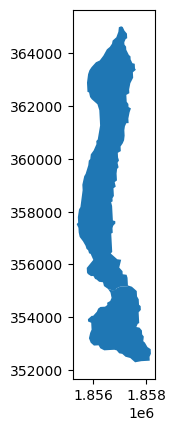

In [18]:
gdf.plot()

In [19]:
# important step
# rechunk the dataset to solve the memory limit issue
ds = ds.chunk(chunks={'time':1})

## Clip AORC to the extent of the subset hydrofabric geometries

Analysis of Record for Calibration (AORC)

Add catchment ids to the geodataset. These will be used to perform zonal statistics later on.

In [20]:
%%time

# create zonal id column
gdf['cat'] = gdf.id.str.split('-').str[-1].astype(int)

# clip AORC to the extent of the hydrofabric geometries
ds = ds.rio.clip(gdf.geometry.values,
                 gdf.crs,
                 drop=True,
                 invert=False, from_disk=True)

# select a single array of data to use as a template
lwdown_data = ds.isel(time=0).LWDOWN

# create a grid for the geocube
out_grid = make_geocube(
    vector_data=gdf,
    measurements=["cat"],
    like=ds # ensure the data are on the same grid
)

# add the catchment variable to the original dataset
ds = ds.assign_coords(cat = (['y','x'], out_grid.cat.data))

# compute the unique catchment IDs which will be used to compute zonal statistics
catchment_ids = numpy.unique(ds.cat.data[~numpy.isnan(ds.cat.data)])

print(f'The dataset contains {len(catchment_ids)} catchments')

The dataset contains 2 catchments
CPU times: user 2.46 s, sys: 275 ms, total: 2.73 s
Wall time: 2.57 s


In [21]:
ds

<xarray.Dataset>
Dimensions:      (time: 200, y: 12, x: 3)
Coordinates:
  * time         (time) datetime64[ns] 2017-10-25T22:00:00 ... 2017-11-03T05:...
    lon          (y, x) float64 dask.array<chunksize=(12, 3), meta=np.ndarray>
    lat          (y, x) float64 dask.array<chunksize=(12, 3), meta=np.ndarray>
  * x            (x) float64 1.856e+06 1.857e+06 1.858e+06
  * y            (y) float64 3.635e+05 3.625e+05 ... 3.535e+05 3.525e+05
    spatial_ref  int64 0
    cat          (y, x) float64 nan 6.989e+05 6.989e+05 ... nan nan 6.989e+05
Data variables:
    LWDOWN       (time, y, x) float32 dask.array<chunksize=(1, 12, 3), meta=np.ndarray>
    PSFC         (time, y, x) float32 dask.array<chunksize=(1, 12, 3), meta=np.ndarray>
    Q2D          (time, y, x) float32 dask.array<chunksize=(1, 12, 3), meta=np.ndarray>
    RAINRATE     (time, y, x) float32 dask.array<chunksize=(1, 12, 3), meta=np.ndarray>
    SWDOWN       (time, y, x) float32 dask.array<chunksize=(1, 12, 3), meta=np.ndarray>
    T2D          (time, y, x) float32 dask.array<chunksize=(1, 12, 3), meta=np.ndarray>
    Times        (time) |S20 dask.array<chunksize=(1,), meta=np.ndarray>
    U2D          (time, y, x) float32 dask.array<chunksize=(1, 12, 3), meta=np.ndarray>
    V2D          (time, y, x) float32 dask.array<chunksize=(1, 12, 3), meta=np.ndarray>

## Preview the gridded catchments over the watershed vector boundary

Note that the method we're using will associate grid cell with the watershed that it overlaps the most with. There are more advanced ways to create a mapping using various interpolation methods that will distribute values cells across all watershed boundaries that they intersect with. This is left as a future exercize. 

Text(0.5, 1.03, 'wb-698891')

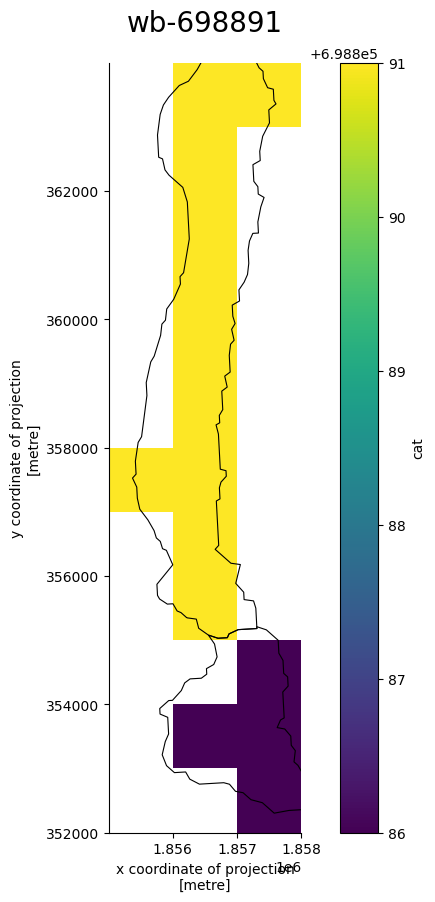

In [23]:
figure, ax = plt.subplots(figsize=(10, 10))


# plot the gridded catchment mapping
ds.cat.plot()

## create a discrete color mapping such that each catchment 
## is represented by a single color
# cmap = colors.ListedColormap(['green', 'lightskyblue', 'cyan', 'red', 'navy'])
# bounds = [catchment_ids[0]] + [c+0.9 for c in catchment_ids]
# norm = colors.BoundaryNorm(bounds, cmap.N)
# ds.cat.plot(cmap=cmap, norm=norm, ax=ax)

# preview map geometries
map_wd = gdf.iloc[:].plot(ax=ax, linewidth=0.8, edgecolor='k', facecolor='None');

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.set_title(f"{wb_id}", fontsize=20, y=1.03)

## Compute basin-averaged forcing data

Define functions that will be used to perform basin averages on the AORC data. These functions leverage `dask` to parallelize the computation.

In [24]:
# call once per catchment
# distribute zonal stats to sub processes
def perform_zonal_computation(ds, cat_id):

    # subset by catchment id
    ds_catchment = ds.where(ds.cat==cat_id, drop=True)
#    ds_catchement_future = client.scatter(ds_catchment, broadcast=True)
    
    delayed = []
    # loop over variables   
    for variable in ['LWDOWN', 'PSFC',
                     'Q2D', 'RAINRATE', 'SWDOWN',
                     'T2D', 'U2D', 'V2D']:
                
        delay = dask.delayed(compute_zonal_mean)(ds_catchment[variable], variable)
        delayed.append(delay)
        
    res = dask.compute(*delayed)
    
    # combine outputs (list of dicts) into a single dict.
    res = {k: v for d in res for k, v in d.items()}
    
    # return results
    return {f'cat-{int(cat_id)}': res}

def compute_zonal_mean(ds, variable):
    return {variable: ds.mean(dim=['x','y']).values}

Slice the data to the temporal period of our choice.

In [25]:
# define the start and end time of the data we want to use
start_time = f'{year}-10-26 00:00' 
end_time = f'{year}-11-02 00:00' # Tropical Storm Philippe | 26-Oct-2017 to 1-Nov-2017


# isolate the desired time period of our data
ds_subset = ds.sortby('time').sel(time=slice(start_time, end_time))

print(f'The dataset contains {len(ds_subset.time)} timesteps')

The dataset contains 169 timesteps


In [26]:
print(f'Available time range: {ds_subset.Times.min().values.item()} -> {ds_subset.Times.max().values.item()}')

Available time range: b'2017-10-26_00:00:00' -> b'2017-11-02_00:00:00'


Let's rechunk our data now that we have many fewer elements.

In [27]:
ds_subset = ds_subset.chunk(chunks={'time': 1000})

In [28]:
ds_subset.chunks

Frozen({'y': (12,), 'x': (3,), 'time': (169,)})

Drop all data that we don't need. The goal here is to make the dataset as small as possible before we start running computations on the data.

In [29]:
# drop unused coordinates
ds_subset = ds_subset.drop(['lat','lon'])

Tell `dask` to perform the subsetting computations on the data now. That way when we process the zonal statistics, the entire dataset won't need to be moved around. This will save a considerable amount of processing in future steps time.

In [30]:
%%time 
ds_subset = ds_subset.compute()

CPU times: user 47.6 s, sys: 8.83 s, total: 56.4 s
Wall time: 6min 35s


Scatter the dataset to the cluster so all workers will have access to it. This is good practice and especially necessary if working on a large dataset.

In [31]:
%%time
scattered_ds = client.scatter(ds_subset, broadcast=True)

CPU times: user 30.3 ms, sys: 4.63 ms, total: 35 ms
Wall time: 50.7 ms


Build a list of `delayed` tasks. This will not execute the computation.

In [32]:
%%time
delayed = []

# loop over each catchment in our domain
# create delayed tasks to compute zonal mean
for cat_id in catchment_ids:
    delay = dask.delayed(perform_zonal_computation)(scattered_ds, cat_id)
    delayed.append(delay)

CPU times: user 559 µs, sys: 0 ns, total: 559 µs
Wall time: 500 µs


Invoke the computation using `dask.compute`.

In [33]:
%%time 

# run the computation
results = dask.compute(*delayed)

CPU times: user 58.7 ms, sys: 9.26 ms, total: 67.9 ms
Wall time: 127 ms


Save the basin averaged meteorological data in the format expected by `ngen`.

The summarized AORC variables need to be mapped to the `ngen` model that we'll be using. The following table illustrates the mapping.

|AORC Variable Name|NGEN Variable Name|Description|
|---|---|---|
| LWDOWN   | DLWRF_surface         | Surface downward long-wave radiation flux (W m-2) 
| PSFC     | PRES_surface          | Surface Pressure (Pa)
| Q2D      | SPFH_2maboveground    | 2-m Specific Humidity (kg kg-1)
| RAINRATE | ---                   | precipitation_flux (mm s^-1)
| SWDOWN   | DSWRF_surface         | Surface downward short-wave radiation flux (W m-2)
| T2D      | TMP_2maboveground     | 2-m Air Temperature (K)
| U2D      | UGRD_10maboveground   | 10-m U-component of wind (m s-1)
| V2D      | VGRD_10maboveground   | 10-m V-component of wind (m s-1)
| ---      | APCP_surface          | Surface precipitation (kg/m^2)

Note: our `ngen` model is expecting shortwave and longwave radiation at a height of 0 meters above ground whereas the AORC data has values are 2 meters above ground.

References: [tshirt_c.h](https://github.com/NOAA-OWP/ngen/blob/f2725dfbb52f3af5083ce927e69733edbf059f57/models/tshirt/include/tshirt_c.h#L52), [sample forcing csv](https://github.com/NOAA-OWP/ngen/blob/master/data/forcing/cat-27_2015-12-01%2000_00_00_2015-12-30%2023_00_00.csv)

## Save data as csv files

In [34]:
# compute the date range for our data using start and end times
# that were used in the subsetting process.
dates = pandas.date_range(start_time, end_time, freq="60min")

# save the zonal means for each catchment
for dat in tqdm(results):
    for cat in dat:
        df = pandas.DataFrame({k:list(v) for k,v in dat[cat].items()})
        df.fillna(0., inplace=True)
        
        # convert rainrate from mm/s to kg/m2
        # mm/s - mm/hr = df.RAINRATE * 3600
        # since the timestep is one hour, this is effectively the total rain in mm.
        # 1 mm of rainfall is equal to 1kg/m2 so our conversion is:
        # NOTE: we should only be considering the fraction of liquid precip which can
        #       be computed using LQFRAC. However LQFRAC is zero for our data which 
        #       does not seem correct, so we'll assume that all precip is liquid. This
        #       is something that needs to be revisited.
        df['APCP_surface'] = df.RAINRATE * 3600

        # rename columns to match the variable names expected by the ngen t-shirt model
        df.rename(columns={
            'LWDOWN'   : 'DLWRF_surface',
            'PSFC'     : 'PRES_surface',
            'Q2D'      : 'SPFH_2maboveground',
            'SWDOWN'   : 'DSWRF_surface',
            'T2D'      : 'TMP_2maboveground',
            'U2D'      : 'UGRD_10maboveground',
            'V2D'      : 'VGRD_10maboveground',
            'RAINRATE' : 'precip_rate',
            },
                  inplace=True)
        
        # add the time index
        df['time'] = dates
        df.set_index('time', inplace=True)


        # write to file
        with open(f'{wb_id}/forcings/{cat}.csv', 'w') as f:
            # Note: saving "precip_rate" because this column exists in the example 
            #       forcing files. It's not clear if this is being used or not.
            df.to_csv(f,
                      columns = ['APCP_surface',
                                 'DLWRF_surface',
                                 'DSWRF_surface',
                                 'PRES_surface',
                                 'SPFH_2maboveground',
                                 'TMP_2maboveground',
                                 'UGRD_10maboveground',
                                 'VGRD_10maboveground',
                                 'precip_rate'])

  0%|          | 0/2 [00:00<?, ?it/s]

In [35]:
df

,DLWRF_surface,PRES_surface,SPFH_2maboveground,precip_rate,DSWRF_surface,TMP_2maboveground,UGRD_10maboveground,VGRD_10maboveground,APCP_surface
time,,,,,,,,,
2017-10-26 00:00:00,333.697205,100925.531250,0.008963,0.000002,0.0,293.730896,5.902008,-0.907043,0.005504
2017-10-26 01:00:00,333.697205,100925.531250,0.008963,0.000002,0.0,293.730896,5.902008,-0.907043,0.005504
2017-10-26 02:00:00,308.586548,100970.406250,0.008149,0.000009,0.0,293.155792,8.333531,-5.988395,0.030983
2017-10-26 03:00:00,308.586548,100970.406250,0.008149,0.000009,0.0,293.155792,8.333531,-5.988395,0.030983
2017-10-26 04:00:00,308.586548,100970.406250,0.008149,0.000009,0.0,293.155792,8.333531,-5.988395,0.030983
...,...,...,...,...,...,...,...,...,...
2017-11-01 20:00:00,363.579193,102419.507812,0.013074,0.000000,0.0,295.983368,-3.932825,2.443230,0.000000
2017-11-01 21:00:00,363.579193,102419.507812,0.013074,0.000000,0.0,295.983368,-3.932825,2.443230,0.000000
2017-11-01 22:00:00,363.579193,102419.507812,0.013074,0.000000,0.0,295.983368,-3.932825,2.443230,0.000000


In [36]:
dates

DatetimeIndex(['2017-10-26 00:00:00', '2017-10-26 01:00:00',
               '2017-10-26 02:00:00', '2017-10-26 03:00:00',
               '2017-10-26 04:00:00', '2017-10-26 05:00:00',
               '2017-10-26 06:00:00', '2017-10-26 07:00:00',
               '2017-10-26 08:00:00', '2017-10-26 09:00:00',
               ...
               '2017-11-01 15:00:00', '2017-11-01 16:00:00',
               '2017-11-01 17:00:00', '2017-11-01 18:00:00',
               '2017-11-01 19:00:00', '2017-11-01 20:00:00',
               '2017-11-01 21:00:00', '2017-11-01 22:00:00',
               '2017-11-01 23:00:00', '2017-11-02 00:00:00'],
              dtype='datetime64[ns]', length=169, freq='60T')

In [37]:
# check the number of catchments. 
print(gdf.shape[0])
print(len(results))

# If these are not equal, run the following code cell.

2
2


Here is an example showing why some catchments are missing in the results.

<img src="./figures/missing_catchment_example.png">

In [44]:
computed_catchments = [list(r.keys())[0] for r in results]
for cat_id in gdf['cat'].values:
    known_catchment = f'cat-{int(cat_id)}'
    if known_catchment not in computed_catchments:
        print(f'Creating Synthetic Forcing for {known_catchment}')
        synthetic_df = pandas.DataFrame(0, index=df.index, columns=['APCP_surface',
                                                                    'DLWRF_surface',
                                                                    'PRES_surface',
                                                                    'SPFH_2maboveground',
                                                                    'DSWRF_surface',
                                                                    'TMP_2maboveground',
                                                                    'UGRD_10maboveground',
                                                                    'VGRD_10maboveground',
                                                                    'precip_rate'])
        # write to file
        with open(f'{wb_id}/forcings/{known_catchment}.csv', 'w') as f:
            df.to_csv(f,
                      columns = ['APCP_surface',
                                 'DLWRF_surface',
                                 'DSWRF_surface',
                                 'PRES_surface',
                                 'SPFH_2maboveground',
                                 'TMP_2maboveground',
                                 'UGRD_10maboveground',
                                 'VGRD_10maboveground',
                                 'precip_rate'])
            
        

Creating Synthetic Forcing for cat-698886


## Run all the watersheds in the New York City

  0%|          | 0/7 [00:00<?, ?it/s]

Preparation of geometries for wb-694856 watershed is done!
The dataset contains 4068 catchments
Clipping AORC to the extent of the subset hydrofabric geometries for wb-694856 watershed is done!


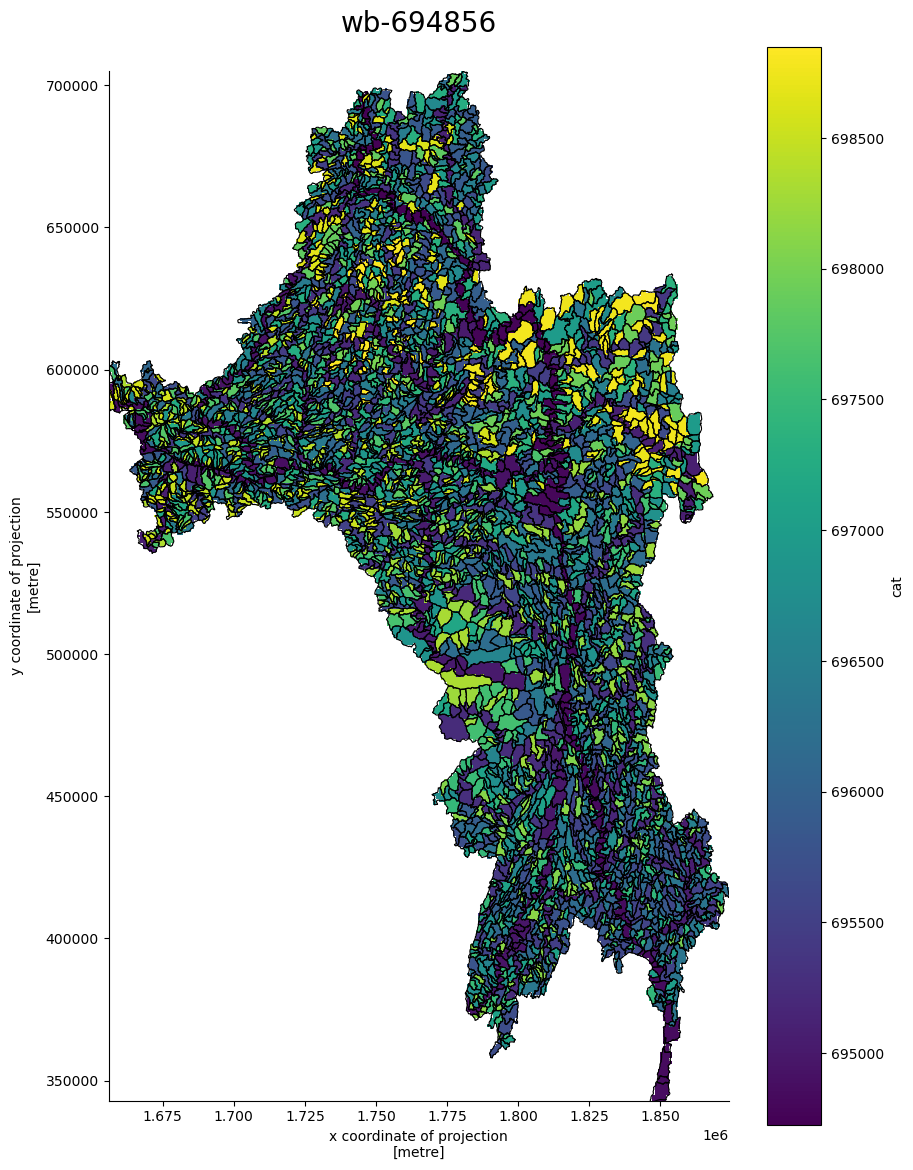

The dataset contains 169 timesteps
Frozen({'y': (362,), 'x': (218,), 'time': (169,)})
Computation of basin-averaged forcing data for wb-694856 watershed is done!


  0%|          | 0/4068 [00:00<?, ?it/s]

4124
4068
Creating Synthetic Forcing for cat-694734
Creating Synthetic Forcing for cat-695825
Creating Synthetic Forcing for cat-695826
Creating Synthetic Forcing for cat-695124
Creating Synthetic Forcing for cat-695661
Creating Synthetic Forcing for cat-695128
Creating Synthetic Forcing for cat-694758
Creating Synthetic Forcing for cat-694993
Creating Synthetic Forcing for cat-695145
Creating Synthetic Forcing for cat-695384
Creating Synthetic Forcing for cat-695839
Creating Synthetic Forcing for cat-697926
Creating Synthetic Forcing for cat-695392
Creating Synthetic Forcing for cat-694872
Creating Synthetic Forcing for cat-697241
Creating Synthetic Forcing for cat-697758
Creating Synthetic Forcing for cat-695072
Creating Synthetic Forcing for cat-697767
Creating Synthetic Forcing for cat-694921
Creating Synthetic Forcing for cat-698420
Creating Synthetic Forcing for cat-694942
Creating Synthetic Forcing for cat-698405
Creating Synthetic Forcing for cat-697707
Creating Synthetic Forci

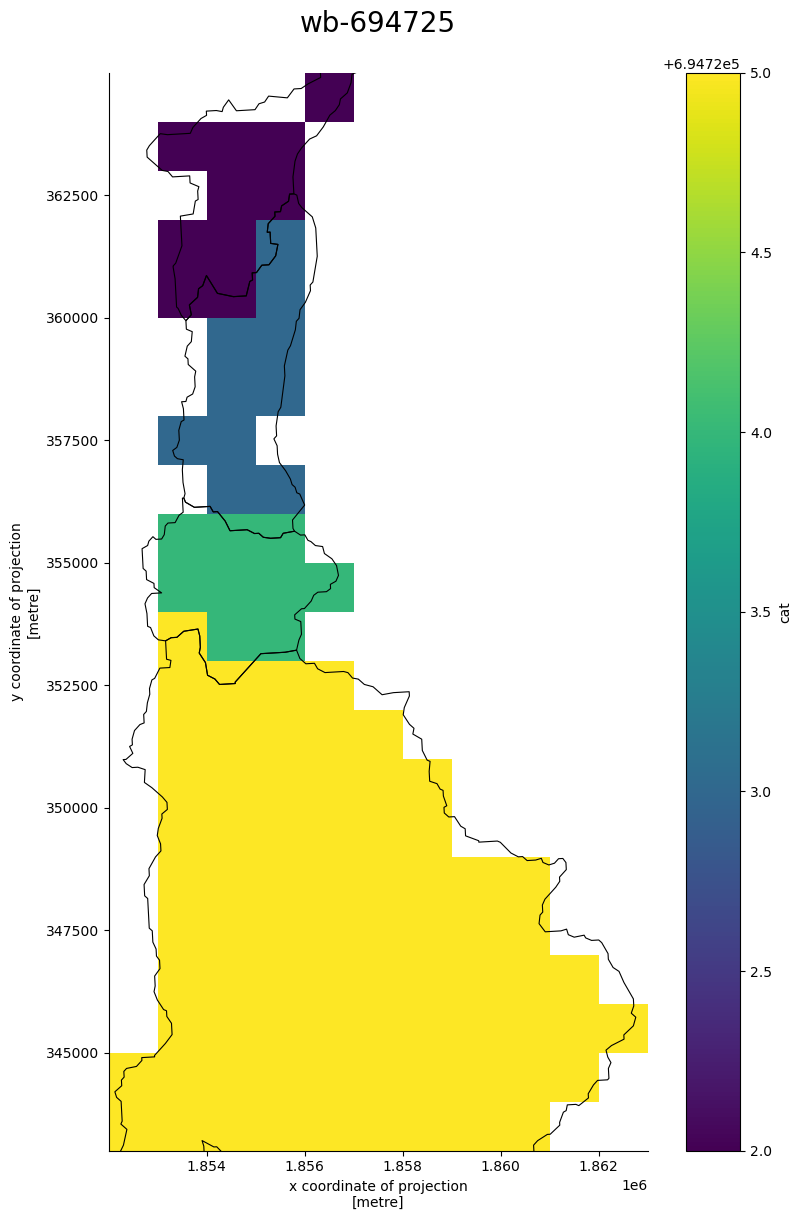

The dataset contains 169 timesteps
Frozen({'y': (22,), 'x': (11,), 'time': (169,)})
Computation of basin-averaged forcing data for wb-694725 watershed is done!


  0%|          | 0/4 [00:00<?, ?it/s]

4
4
The shape of 'gdf' and the length of 'results' are equal.
Processing of wb-694725 watershed is done!
Preparation of geometries for wb-694855 watershed is done!
The dataset contains 4 catchments
Clipping AORC to the extent of the subset hydrofabric geometries for wb-694855 watershed is done!


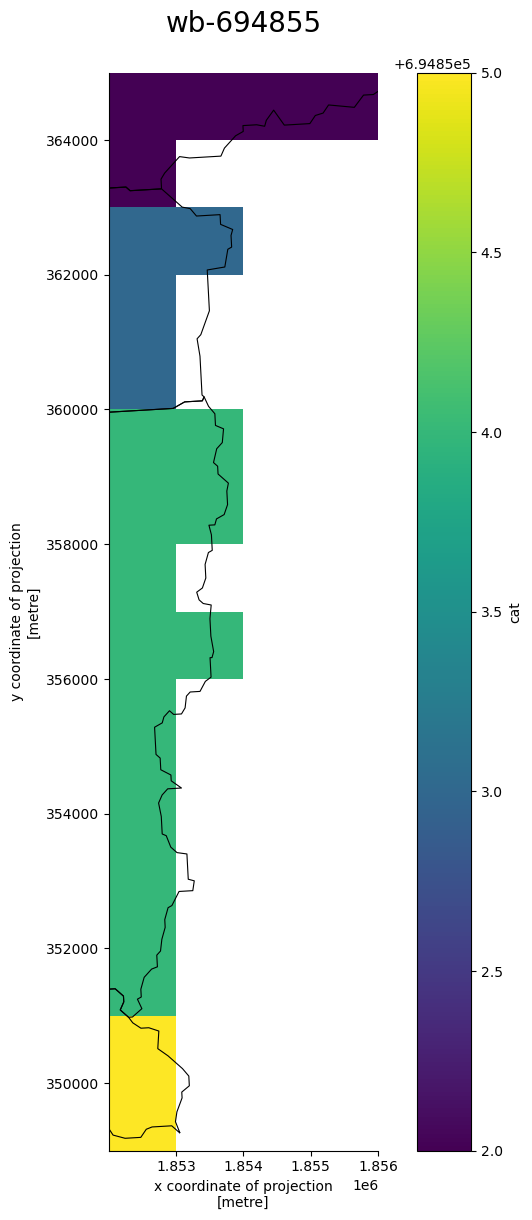

The dataset contains 169 timesteps
Frozen({'y': (16,), 'x': (4,), 'time': (169,)})
Computation of basin-averaged forcing data for wb-694855 watershed is done!


  0%|          | 0/4 [00:00<?, ?it/s]

4123
4
Creating Synthetic Forcing for cat-696657
Creating Synthetic Forcing for cat-696466
Creating Synthetic Forcing for cat-694726
Creating Synthetic Forcing for cat-696467
Creating Synthetic Forcing for cat-698646
Creating Synthetic Forcing for cat-696468
Creating Synthetic Forcing for cat-697852
Creating Synthetic Forcing for cat-696945
Creating Synthetic Forcing for cat-698644
Creating Synthetic Forcing for cat-697299
Creating Synthetic Forcing for cat-698645
Creating Synthetic Forcing for cat-694727
Creating Synthetic Forcing for cat-697851
Creating Synthetic Forcing for cat-694728
Creating Synthetic Forcing for cat-696964
Creating Synthetic Forcing for cat-695784
Creating Synthetic Forcing for cat-695785
Creating Synthetic Forcing for cat-698647
Creating Synthetic Forcing for cat-697300
Creating Synthetic Forcing for cat-697301
Creating Synthetic Forcing for cat-697853
Creating Synthetic Forcing for cat-695786
Creating Synthetic Forcing for cat-698648
Creating Synthetic Forcing 

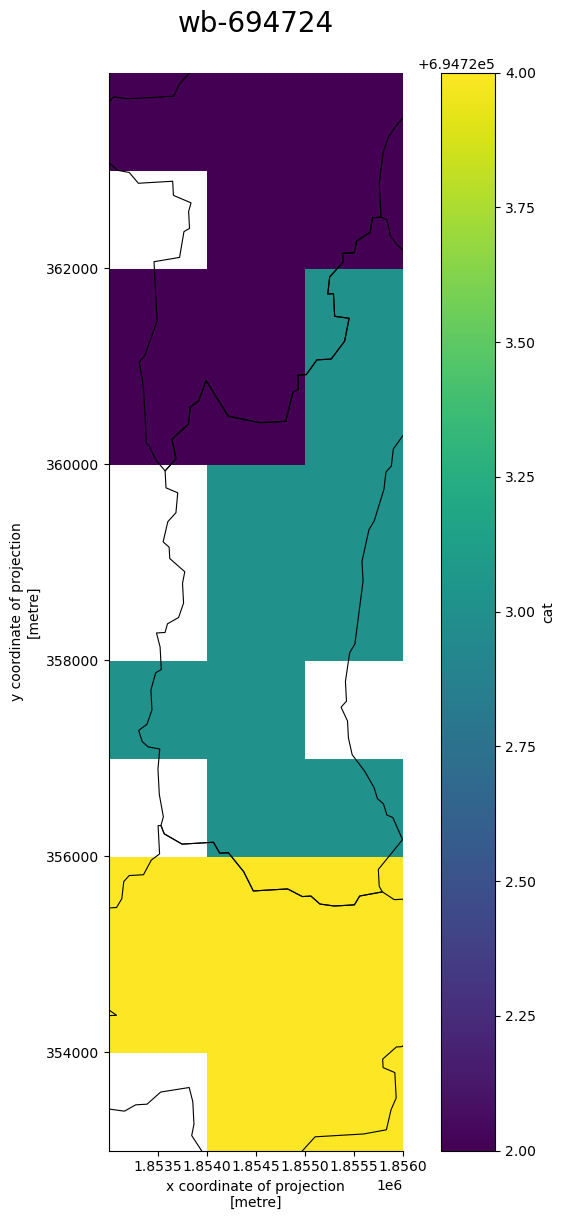

The dataset contains 169 timesteps
Frozen({'y': (11,), 'x': (3,), 'time': (169,)})
Computation of basin-averaged forcing data for wb-694724 watershed is done!


  0%|          | 0/3 [00:00<?, ?it/s]

3
3
The shape of 'gdf' and the length of 'results' are equal.
Processing of wb-694724 watershed is done!
Preparation of geometries for wb-694854 watershed is done!
The dataset contains 2 catchments
Clipping AORC to the extent of the subset hydrofabric geometries for wb-694854 watershed is done!


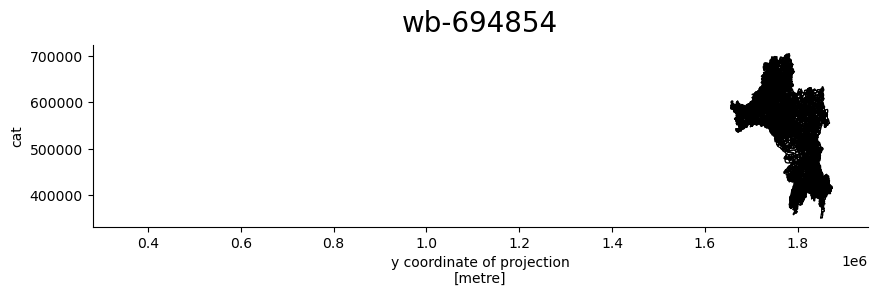

The dataset contains 169 timesteps
Frozen({'y': (7,), 'x': (1,), 'time': (169,)})
Computation of basin-averaged forcing data for wb-694854 watershed is done!


  0%|          | 0/2 [00:00<?, ?it/s]

4122
2
Creating Synthetic Forcing for cat-696657
Creating Synthetic Forcing for cat-696466
Creating Synthetic Forcing for cat-694726
Creating Synthetic Forcing for cat-696467
Creating Synthetic Forcing for cat-698646
Creating Synthetic Forcing for cat-696468
Creating Synthetic Forcing for cat-697852
Creating Synthetic Forcing for cat-696945
Creating Synthetic Forcing for cat-698644
Creating Synthetic Forcing for cat-697299
Creating Synthetic Forcing for cat-698645
Creating Synthetic Forcing for cat-694727
Creating Synthetic Forcing for cat-697851
Creating Synthetic Forcing for cat-694728
Creating Synthetic Forcing for cat-696964
Creating Synthetic Forcing for cat-695784
Creating Synthetic Forcing for cat-695785
Creating Synthetic Forcing for cat-698647
Creating Synthetic Forcing for cat-697300
Creating Synthetic Forcing for cat-697301
Creating Synthetic Forcing for cat-697853
Creating Synthetic Forcing for cat-695786
Creating Synthetic Forcing for cat-698648
Creating Synthetic Forcing 

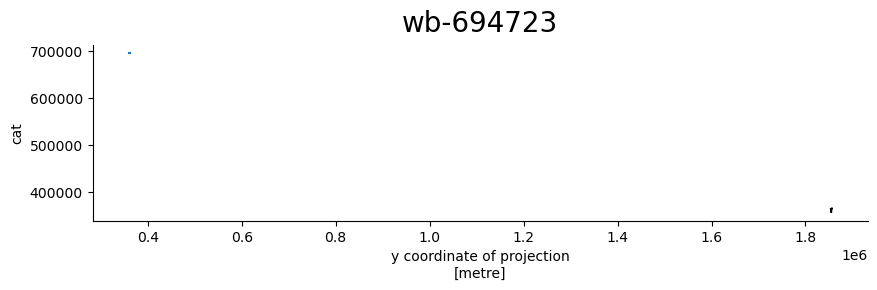

The dataset contains 169 timesteps
Frozen({'y': (5,), 'x': (1,), 'time': (169,)})
Computation of basin-averaged forcing data for wb-694723 watershed is done!


  0%|          | 0/2 [00:00<?, ?it/s]

2
2
The shape of 'gdf' and the length of 'results' are equal.
Processing of wb-694723 watershed is done!
Preparation of geometries for wb-694722 watershed is done!
The dataset contains 1 catchments
Clipping AORC to the extent of the subset hydrofabric geometries for wb-694722 watershed is done!


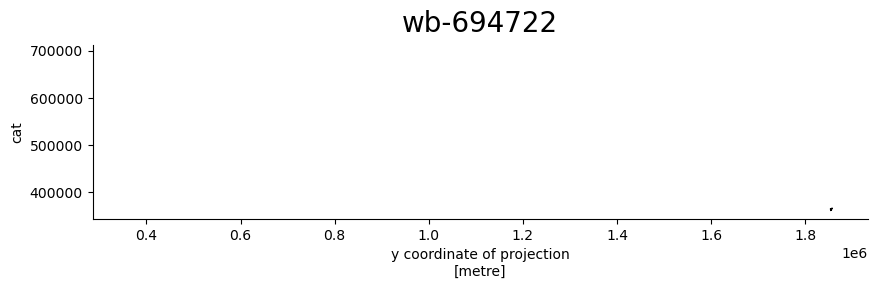

The dataset contains 169 timesteps
Frozen({'y': (2,), 'x': (1,), 'time': (169,)})
Computation of basin-averaged forcing data for wb-694722 watershed is done!


  0%|          | 0/1 [00:00<?, ?it/s]

1
1
The shape of 'gdf' and the length of 'results' are equal.
Processing of wb-694722 watershed is done!


In [22]:
# List of watersheds in NYC area
ids_list = ['wb-694856', 'wb-694725', 'wb-694855', 'wb-694724', 'wb-694854', 'wb-694723', 'wb-694722']

# 'wb-698891' is giving parameter error. Run this watershed separately 

for wb_id in tqdm(ids_list):
    
    ################################################################
    ### Add spatial reference to the model domain 
    ################################################################
    
    # prepare geometries for spatial averaging
    gdf = geopandas.read_file(f'{wb_id}/config/{wb_id.split("_")[0]}_upstream_subset.gpkg', layer='divides')

    # convert these data into the projection of our forcing data
    target_crs = pyproj.Proj(proj='lcc',
                           lat_1=30.,
                           lat_2=60., 
                           lat_0=40.0000076293945, lon_0=-97., # Center point
                           a=6370000, b=6370000) 

    gdf = gdf.to_crs(target_crs.crs)
    
    # important step
    # rechunk the dataset to solve the memory limit issue
    ds = ds.chunk(chunks={'time':1})
    
    print(f"Preparation of geometries for {wb_id} watershed is done!")
    
    #################################################################
    ### Clip AORC to the extent of the subset hydrofabric geometries
    #################################################################
    
    # create zonal id column
    gdf['cat'] = gdf.id.str.split('-').str[-1].astype(int)

    # clip AORC to the extent of the hydrofabric geometries
    ds = ds.rio.clip(gdf.geometry.values,
                     gdf.crs,
                     drop=True,
                     invert=False)

    # select a single array of data to use as a template
    # lwdown_data = ds.isel(time=0).LWDOWN

    # create a grid for the geocube
    out_grid = make_geocube(
        vector_data=gdf,
        measurements=["cat"],
        like=ds # ensure the data are on the same grid
    )

    # add the catchment variable to the original dataset
    ds = ds.assign_coords(cat = (['y','x'], out_grid.cat.data))

    # compute the unique catchment IDs which will be used to compute zonal statistics
    catchment_ids = numpy.unique(ds.cat.data[~numpy.isnan(ds.cat.data)])

    print(f'The dataset contains {len(catchment_ids)} catchments')
    
    print(f"Clipping AORC to the extent of the subset hydrofabric geometries for {wb_id} watershed is done!")
    
    ######################################################################
    ### Preview the gridded catchments over the watershed vector boundary
    ######################################################################
    
    figure, ax = plt.subplots(figsize=(10, 14))


    # plot the gridded catchment mapping
    ds.cat.plot()

    ## create a discrete color mapping such that each catchment 
    ## is represented by a single color
    # cmap = colors.ListedColormap(['green', 'lightskyblue', 'cyan', 'red', 'navy'])
    # bounds = [catchment_ids[0]] + [c+0.9 for c in catchment_ids]
    # norm = colors.BoundaryNorm(bounds, cmap.N)
    # ds.cat.plot(cmap=cmap, norm=norm, ax=ax)

    # preview map geometries
    map_wd = gdf.iloc[:].plot(ax=ax, linewidth=0.8, edgecolor='k', facecolor='None');

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    ax.set_title(f"{wb_id}", fontsize=20, y=1.03)
    
    plt.show()

    #####################################################################
    ### Compute basin-averaged forcing data
    #####################################################################
    
    # define the start and end time of the data we want to use
    start_time = f'{year}-10-26 00:00' 
    end_time = f'{year}-11-02 00:00' # Tropical Storm Philippe | 26-Oct-2017 to 1-Nov-2017


    # isolate the desired time period of our data
    ds_subset = ds.sortby('time').sel(time=slice(start_time, end_time))

    print(f'The dataset contains {len(ds_subset.time)} timesteps')
    
    # Let's rechunk our data now that we have many fewer elements.
    ds_subset = ds_subset.chunk(chunks={'time': 1000})
    
    print(ds_subset.chunks)
    
    ## Drop all data that we don't need. 
    ## The goal here is to make the dataset as small as possible before we start running computations on the data.
    # drop unused coordinates
    ds_subset = ds_subset.drop(['lat','lon'])
    
    ## Tell dask to perform the subsetting computations on the data now.
    ds_subset = ds_subset.compute()
    
    # Scatter the dataset to the cluster so all workers will have access to it.
    scattered_ds = client.scatter(ds_subset, broadcast=True)
    
    # Build a list of delayed tasks. This will not execute the computation
    delayed = []

    # loop over each catchment in our domain
    # create delayed tasks to compute zonal mean
    for cat_id in catchment_ids:
        delay = dask.delayed(perform_zonal_computation)(scattered_ds, cat_id)
        delayed.append(delay)
        
    # Invoke the computation using dask.compute.
    # run the computation
    results = dask.compute(*delayed)
    
    print(f"Computation of basin-averaged forcing data for {wb_id} watershed is done!")
    
    #####################################################################
    ### Save data as csv files
    #####################################################################
    
    # compute the date range for our data using start and end times
    # that were used in the subsetting process.
    dates = pd.date_range(start_time, end_time, freq="60min")

    # save the zonal means for each catchment
    for dat in tqdm(results):
        for cat in dat:
            df = pd.DataFrame({k:list(v) for k,v in dat[cat].items()})
            df.fillna(0., inplace=True)

            # convert rainrate from mm/s to kg/m2
            # mm/s - mm/hr = df.RAINRATE * 3600
            # since the timestep is one hour, this is effectively the total rain in mm.
            # 1 mm of rainfall is equal to 1kg/m2 so our conversion is:
            # NOTE: we should only be considering the fraction of liquid precip which can
            #       be computed using LQFRAC. However LQFRAC is zero for our data which 
            #       does not seem correct, so we'll assume that all precip is liquid. This
            #       is something that needs to be revisited.
            df['APCP_surface'] = df.RAINRATE * 3600

            # rename columns to match the variable names expected by the ngen t-shirt model
            df.rename(columns={
                'LWDOWN'   : 'DLWRF_surface',
                'PSFC'     : 'PRES_surface',
                'Q2D'      : 'SPFH_2maboveground',
                'SWDOWN'   : 'DSWRF_surface',
                'T2D'      : 'TMP_2maboveground',
                'U2D'      : 'UGRD_10maboveground',
                'V2D'      : 'VGRD_10maboveground',
                'RAINRATE' : 'precip_rate',
                },
                      inplace=True)

            # add the time index
            df['time'] = dates
            df.set_index('time', inplace=True)


            # write to file
            with open(f'{wb_id}/forcings/{cat}.csv', 'w') as f:
                # Note: saving "precip_rate" because this column exists in the example 
                #       forcing files. It's not clear if this is being used or not.
                df.to_csv(f,
                          columns = ['APCP_surface',
                                     'DLWRF_surface',
                                     'DSWRF_surface',
                                     'PRES_surface',
                                     'SPFH_2maboveground',
                                     'TMP_2maboveground',
                                     'UGRD_10maboveground',
                                     'VGRD_10maboveground',
                                     'precip_rate'])
                
    # check the number of catchments. 
    print(gdf.shape[0])
    print(len(results))

    # check if the shape of 'gdf' and the length of 'results' are equal
    if gdf.shape[0] != len(results):
        computed_catchments = [list(r.keys())[0] for r in results]
        for cat_id in gdf['cat'].values:
            known_catchment = f'cat-{int(cat_id)}'
            if known_catchment not in computed_catchments:
                print(f'Creating Synthetic Forcing for {known_catchment}')
                synthetic_df = pd.DataFrame(0, index=df.index, columns=['APCP_surface',
                                                                        'DLWRF_surface',
                                                                        'PRES_surface',
                                                                        'SPFH_2maboveground',
                                                                        'DSWRF_surface',
                                                                        'TMP_2maboveground',
                                                                        'UGRD_10maboveground',
                                                                        'VGRD_10maboveground',
                                                                        'precip_rate'])
                # write to file
                with open(f'{wb_id}/forcings/{known_catchment}.csv', 'w') as f:
                    synthetic_df.to_csv(f,
                              columns = ['APCP_surface',
                                         'DLWRF_surface',
                                         'DSWRF_surface',
                                         'PRES_surface',
                                         'SPFH_2maboveground',
                                         'TMP_2maboveground',
                                         'UGRD_10maboveground',
                                         'VGRD_10maboveground',
                                         'precip_rate'])
    else:
        print("The shape of 'gdf' and the length of 'results' are equal.")
            
    print(f"Processing of {wb_id} watershed is done!")

## Plot all watersheds

  0%|          | 0/8 [00:00<?, ?it/s]

Preparation of geometries for wb-694856 watershed is done!
The dataset contains 4068 catchments
Clipping AORC to the extent of the subset hydrofabric geometries for wb-694856 watershed is done!
Preparation of geometries for wb-694725 watershed is done!
The dataset contains 4 catchments
Clipping AORC to the extent of the subset hydrofabric geometries for wb-694725 watershed is done!
Preparation of geometries for wb-694855 watershed is done!
The dataset contains 4 catchments
Clipping AORC to the extent of the subset hydrofabric geometries for wb-694855 watershed is done!
Preparation of geometries for wb-694724 watershed is done!
The dataset contains 3 catchments
Clipping AORC to the extent of the subset hydrofabric geometries for wb-694724 watershed is done!
Preparation of geometries for wb-694854 watershed is done!
The dataset contains 2 catchments
Clipping AORC to the extent of the subset hydrofabric geometries for wb-694854 watershed is done!
Preparation of geometries for wb-694723 wa

NoDataInBounds: No data found in bounds. Data variable: LWDOWN

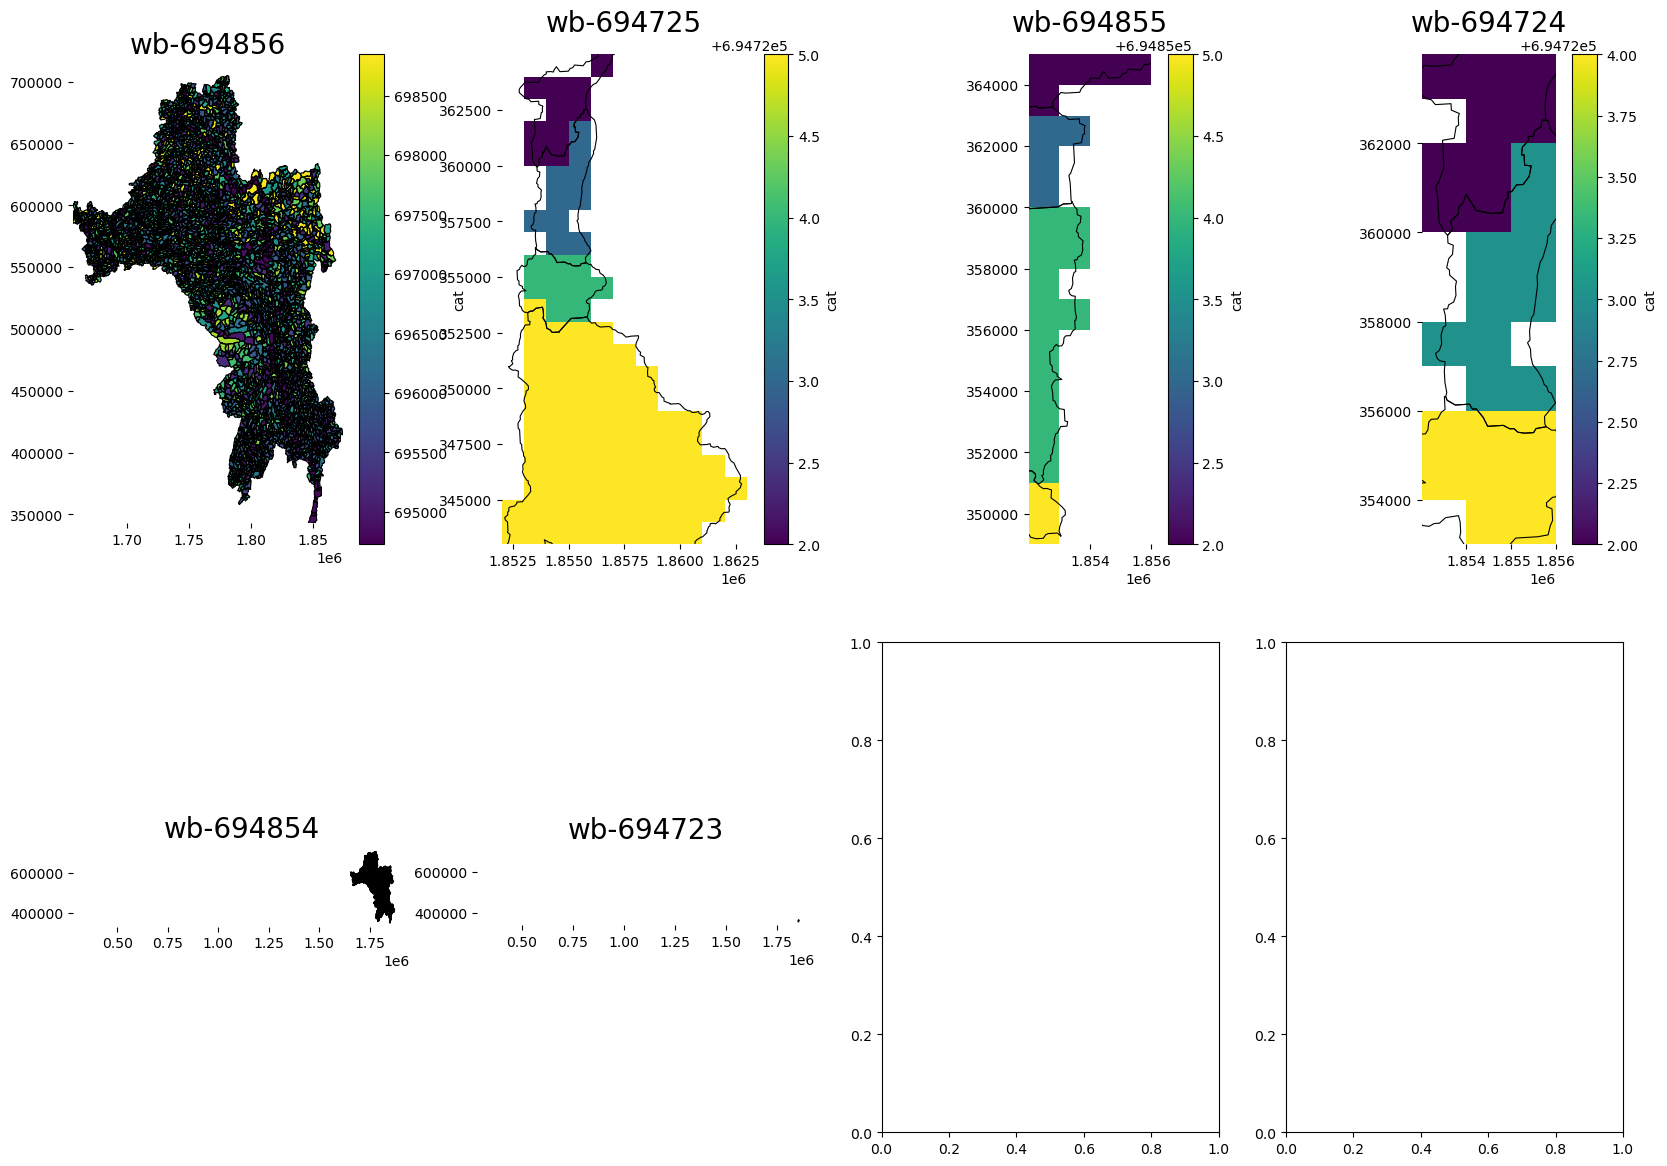

In [16]:
# List of watersheds in NYC area
ids_list = ['wb-694856', 'wb-694725', 'wb-694855', 'wb-694724',  'wb-694854', 'wb-694723', 'wb-698891', 'wb-694722']

# Create a figure with 8 subplots, with 2 rows and 4 columns
fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(20, 14))

# Flatten the axes array so we can easily loop over it
axs = axs.flatten()

for ax, wb_id in zip(axs, tqdm(ids_list)):
    
    ################################################################
    ### Add spatial reference to the model domain 
    ################################################################
    
    # prepare geometries for spatial averaging
    gdf = geopandas.read_file(f'{wb_id}/config/{wb_id.split("_")[0]}_upstream_subset.gpkg', layer='divides')

    # convert these data into the projection of our forcing data
    target_crs = pyproj.Proj(proj='lcc',
                           lat_1=30.,
                           lat_2=60., 
                           lat_0=40.0000076293945, lon_0=-97., # Center point
                           a=6370000, b=6370000) 

    gdf = gdf.to_crs(target_crs.crs)
    
    # important step
    # rechunk the dataset to solve the memory limit issue
    ds = ds.chunk(chunks={'time':1})
    
    print(f"Preparation of geometries for {wb_id} watershed is done!")
    
    #################################################################
    ### Clip AORC to the extent of the subset hydrofabric geometries
    #################################################################
    
    # create zonal id column
    gdf['cat'] = gdf.id.str.split('-').str[-1].astype(int)

    # clip AORC to the extent of the hydrofabric geometries
    ds = ds.rio.clip(gdf.geometry.values,
                     gdf.crs,
                     drop=True,
                     invert=False)

    # select a single array of data to use as a template
    # lwdown_data = ds.isel(time=0).LWDOWN

    # create a grid for the geocube
    out_grid = make_geocube(
        vector_data=gdf,
        measurements=["cat"],
        like=ds # ensure the data are on the same grid
    )

    # add the catchment variable to the original dataset
    ds = ds.assign_coords(cat = (['y','x'], out_grid.cat.data))

    # compute the unique catchment IDs which will be used to compute zonal statistics
    catchment_ids = numpy.unique(ds.cat.data[~numpy.isnan(ds.cat.data)])

    print(f'The dataset contains {len(catchment_ids)} catchments')
    
    print(f"Clipping AORC to the extent of the subset hydrofabric geometries for {wb_id} watershed is done!")

    ######################################################################
    ### Preview the gridded catchments over the watershed vector boundary
    ######################################################################
    
    # plot the gridded catchment mapping
    ds.cat.plot(ax=ax)

    # preview map geometries
    gdf.iloc[:].plot(ax=ax, linewidth=0.8, edgecolor='k', facecolor='None')

    # Remove axes labels
    ax.set_xlabel('')
    ax.set_ylabel('')

    # Remove all spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)

    ax.set_title(f"{wb_id}", fontsize=20, y=1.03)

# Adjust the height of the colorbar to 80%
cbar = plt.colorbar(ax=axs.ravel().tolist(), pad=0.01, fraction=0.8)
cbar.set_label('Catchment ID', rotation=270)

# Save the figure as a PNG
plt.savefig('watersheds.png', dpi=300)

plt.show()
